In [1]:
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, Atom
from pmutt.statmech import StatMech, trans, vib, rot, elec
from pmutt.constants import kb, Na


# interactive plots
%matplotlib widget

In [2]:
KB_KCAL: float = kb("kcal/K")
AVOGADRO: float = Na

KB_KCAL_MOL: float = KB_KCAL * AVOGADRO

## Sorted according SO-ZORA

In [3]:
working_directory = Path.cwd() / "../structures/sozora/"

if not working_directory.exists():
    raise ValueError("The working directory does not exist.")

/home/danian/hg2w/calculaT/ThermoChemistry/jupyter/../structures/sozora


In [4]:
list_file_adf = glob(str(working_directory) + '/*.out')
energies_file_adf = working_directory / ('energies.txt')

if not energies_file_adf.exists():
    raise ValueError("The energies file does not exist.")

if not list_file_adf:
    raise ValueError("The list of ADF files does not exist.")

## Reading Coordinates and Frequencies from ADF.2013

In [5]:
find_lines_adf = {}
for file_adf in list_file_adf:
    read_file_adf = Path(file_adf).read_text()

    """ Lines to read the geometry in ADF.2013 """
    start_line_geom = None
    last_line_geom = None
    start_line_freq = None
    last_line_freq = None
    for count, line in enumerate(read_file_adf.split('\n')):

        if line == "                                            *  F R E Q U E N C I E S  *":
            start_line_geom = count + 11
        elif line == " Atomic Masses:":
            last_line_geom = count - 4
        elif line == " List of All Frequencies:":
            start_line_freq = count + 9
        elif line == " Statistical Thermal Analysis  ***  ideal gas assumed  ***":
            last_line_freq = count - 4
        elif start_line_geom and last_line_geom and start_line_freq and last_line_freq:

            break
    find_lines_adf[Path(file_adf).name] = [start_line_geom, last_line_geom, start_line_freq, last_line_freq]

if not find_lines_adf:
    raise ValueError("The lines to read the geometry and frequencies in ADF.2013 does not exist.")

In [6]:
geoms_systems = {}
freqs_systems = {}
energies_systems = {}
for file_adf in list_file_adf:
    with open(Path(file_adf), 'r') as f_adf:
        file_content = f_adf.readlines()

        """Atoms object with ase.Atoms"""
        last_line_geom = find_lines_adf[Path(file_adf).name][1]
        start_line_geom = find_lines_adf[Path(file_adf).name][0]
        lines_geom = last_line_geom - start_line_geom
        coord_system = []
        for i in range(lines_geom):
            line = file_content[start_line_geom + i].split()
            coord_system.append(Atom(line[1], (line[5], line[6], line[7])))
        geoms_systems[Path(file_adf).name] = Atoms(coord_system)

        """Frequencies"""
        last_line_freq = find_lines_adf[Path(file_adf).name][3]
        start_line_freq = find_lines_adf[Path(file_adf).name][2]
        lines_freq = last_line_freq - start_line_freq
        freq_system = []
        for i in range(lines_freq):
            line = file_content[start_line_freq + i].split()
            if float(line[0]) > 20.0:
                freq_system.append(float(line[0]))
        freqs_systems[Path(file_adf).name] = freq_system

    """Energies from ADF.2013 in Ev"""
    with open(energies_file_adf, 'r') as f_energies:
        stop = False
        while stop == False:
            line = f_energies.readline().split()
            if line[0] == Path(file_adf).with_suffix('').name:
                energies_systems[Path(file_adf).name] = float(line[1])
                stop = True

if not geoms_systems:
    raise ValueError("The geometries of the systems does not exist.")
if not freqs_systems:
    raise ValueError("The frequencies of the systems does not exist.")
if not energies_systems:
    raise ValueError("The energies of the systems does not exist.")

In [7]:
translation = {}
vibration = {}
rotation = {}
electronic = {}
for count, file_adf in enumerate(list_file_adf):
    name_file = Path(file_adf).name

    '''Translational'''
    translation[name_file] = trans.FreeTrans(n_degrees=3, atoms=geoms_systems[name_file])

    '''Vibrational'''
    vibration[name_file] = vib.HarmonicVib(vib_wavenumbers=freqs_systems[name_file]) #cm^-1

    '''Rotational'''
    rotation[name_file] = rot.RigidRotor(symmetrynumber=1, atoms=geoms_systems[name_file]) #simmetry point C1

    '''Electronic'''
    electronic[name_file] = elec.GroundStateElec(potentialenergy=float(energies_systems[name_file]), spin=0) #Ev

if not translation:
    raise ValueError("The translational part of the systems does not exist.")
if not vibration:
    raise ValueError("The vibrational part of the systems does not exist.")
if not rotation:
    raise ValueError("The rotational part of the systems does not exist.")
if not electronic:
    raise ValueError("The electronic part of the systems does not exist.")

In [8]:
statmech = {}
for file_adf in list_file_adf:
    name_file = Path(file_adf).name
    name = Path(file_adf).with_suffix('').name
    '''StatMech Initialization'''
    statmech[name_file] = StatMech(name=name,
                            trans_model=translation[name_file],
                            vib_model=vibration[name_file],
                            rot_model=rotation[name_file],
                            elec_model=electronic[name_file])

if not statmech:
    raise ValueError("The statmech of the systems does not exist.")

In [9]:
print('systems     H[kcal/mol]    S[kcal/mol/K]    G[kcal/mol]     T: 298.15 K')
for file_adf in list_file_adf:
    name_file = Path(file_adf).name
    H_statmech = statmech[name_file].get_H(T=298.15, units='kcal/mol')
    S_statmech = statmech[name_file].get_S(T=298.15, units='kcal/mol/K')
    G_statmech = statmech[name_file].get_G(T=298.15, units='kcal/mol')
    print(f"{name_file}:  {H_statmech:.3f}      {S_statmech:.3f}       {G_statmech:.3f}")

systems     H[kcal/mol]    S[kcal/mol/K]    G[kcal/mol]     T: 298.15 K
w5s10.out:  -26702.474      0.124       -26739.555
w5s9.out:  -26704.981      0.123       -26741.711
w6s10.out:  -27049.573      0.130       -27088.411
w5s6.out:  -26711.176      0.120       -26746.822
w6s9.out:  -27049.488      0.135       -27089.753
w6s7.out:  -27052.128      0.130       -27090.758
w5s7.out:  -26705.714      0.115       -26740.100
w2s1.out:  -25668.161      0.077       -25691.234
w6s2.out:  -27059.177      0.123       -27095.863
w4s4.out:  -26361.056      0.116       -26395.700
w6s18.out:  -27031.408      0.147       -27075.240
w3s2.out:  -26016.938      0.099       -26046.364
w6s11.out:  -27049.072      0.127       -27086.809
w6s19.out:  -27059.605      0.127       -27097.547
w6s5.out:  -27056.559      0.131       -27095.725
w5s2.out:  -26722.905      0.113       -26756.606
w5s3.out:  -26719.370      0.115       -26753.703
w5s8.out:  -26698.493      0.132       -26737.733
w6s17.out:  -27037.143 

In [10]:
# df_results = pd.DataFrame(columns=['system', "H[kcal/mol]", "S[kcal/mol/K]", "G[kcal/mol]"])
absolute_thermochemical_results = {}

for file_adf in list_file_adf:

    name_file = Path(file_adf).name

    absolute_thermochemical_results[name_file] = {}

    thermo_data = {
        'temperature[K]': [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
    }

    for temperature in range(1, 500, 1):

        H_statmech = statmech[name_file].get_H(T=temperature, units='kcal/mol')
        S_statmech = statmech[name_file].get_S(T=temperature, units='kcal/mol/K')
        G_statmech = statmech[name_file].get_G(T=temperature, units='kcal/mol')

        thermo_data['temperature[K]'].append(temperature)
        thermo_data['H[kcal/mol]'].append(H_statmech)
        thermo_data['S[kcal/mol/K]'].append(S_statmech)
        thermo_data['G[kcal/mol]'].append(G_statmech)

    absolute_thermochemical_results[name_file] = pd.DataFrame(thermo_data)

if not absolute_thermochemical_results:
    raise ValueError("The absolute thermochemical values of the systems does not exist.")

In [11]:
absolute_thermochemical_results['w6s1.out'].tail()

,temperature[K],H[kcal/mol],S[kcal/mol/K],G[kcal/mol]
494,495,-27050.532374,0.154614,-27127.066251
495,496,-27050.470163,0.154739,-27127.220927
496,497,-27050.407901,0.154865,-27127.375730
497,498,-27050.345590,0.154990,-27127.530657
498,499,-27050.283229,0.155115,-27127.685710


In [12]:
thermochemical_results = absolute_thermochemical_results['w6s20.out'] - absolute_thermochemical_results['w6s1.out']

thermochemical_results['temperature[K]'] = absolute_thermochemical_results['w6s1.out']['temperature[K]']

thermochemical_results.rename(
    columns={
        'temperature[K]': 'T[K]',
        "H[kcal/mol]": "DH[kcal/mol]",
        "S[kcal/mol/K]": "DS[kcal/mol/K]",
        "G[kcal/mol]": "DG[kcal/mol]",
        }, 
    inplace=True, 
    errors='raise',
    )
    
thermochemical_results.head()

,T[K],DH[kcal/mol],DS[kcal/mol/K],DG[kcal/mol]
0,1,2.067010,-0.002733,2.069743
1,2,2.067010,-0.002733,2.072476
2,3,2.067014,-0.002732,2.075209
3,4,2.067044,-0.002723,2.077938
4,5,2.067140,-0.002702,2.080651


In [ ]:
relative_population = np.exp(-thermochemical_results['DG[kcal/mol]'] / KB_KCAL_MOL / thermochemical_results['T[K]'])

relative_population.head()

0.40502719645672675

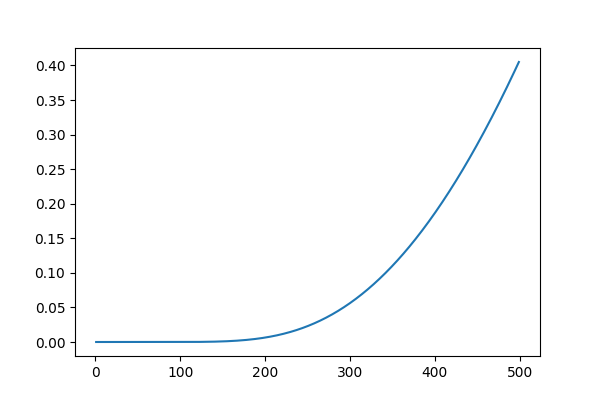

In [14]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot(thermochemical_results['T[K]'], relative_population)

In [ ]:
# thermochemical_results['w4s4.out'].plot(x='temperature', y=['H[kcal/mol]', 'S[kcal/mol/K]', 'G[kcal/mol]'], figsize=(10, 10))
thermochemical_results['w4s4.out'].plot(x='temperature', y=['G[kcal/mol]'], figsize=(4, 4), )